In [1]:
import sys
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split


print("Python:", sys.version.splitlines()[0])
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("scikit-learn:", sklearn.__version__)

Python: 3.12.4 (tags/v3.12.4:8e8a4ba, Jun  6 2024, 19:30:16) [MSC v.1940 64 bit (AMD64)]
pandas: 2.1.4
numpy: 1.26.4
scikit-learn: 1.4.2


In [2]:
raw_path = "C:/Users/user/Desktop/GB/cicids2017_cleaned.csv"
df = pd.read_csv(raw_path)
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,...,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Max,Active Min,Idle Mean,Idle Max,Idle Min,Attack Type
0,22,1266342,41,2664,456,0,64.975610,109.864573,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
1,22,1319353,41,2664,456,0,64.975610,109.864573,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
2,22,160,1,0,0,0,0.000000,0.000000,0,0,...,243,0,32,0.0,0,0,0.0,0,0,Normal Traffic
3,22,1303488,41,2728,456,0,66.536585,110.129945,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
4,35396,77,1,0,0,0,0.000000,0.000000,0,0,...,290,0,32,0.0,0,0,0.0,0,0,Normal Traffic


In [3]:
#clean column names
def clean_column_names(df):
    df = df.copy()
    df.columns = (
        df.columns
        .str.strip()    #remove leading or trailing spaces
        .str.lower()    #lowercase everything
        .str.replace('[^a-z0-9]', '_', regex=True)  #replace nonalphanumeric with _
        .str.replace('_+', '_', regex=True) #no repeated _
    )
    return df
df = clean_column_names(df)
df.head()

,destination_port,flow_duration,total_fwd_packets,total_length_of_fwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,bwd_packet_length_max,bwd_packet_length_min,...,init_win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_max,active_min,idle_mean,idle_max,idle_min,attack_type
0,22,1266342,41,2664,456,0,64.975610,109.864573,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
1,22,1319353,41,2664,456,0,64.975610,109.864573,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
2,22,160,1,0,0,0,0.000000,0.000000,0,0,...,243,0,32,0.0,0,0,0.0,0,0,Normal Traffic
3,22,1303488,41,2728,456,0,66.536585,110.129945,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
4,35396,77,1,0,0,0,0.000000,0.000000,0,0,...,290,0,32,0.0,0,0,0.0,0,0,Normal Traffic


In [4]:
# Display summary statistics
df.select_dtypes(include='number').describe().T  # Transpose for easier reading

,count,mean,std,min,25%,50%,75%,max
destination_port,2520751.0,8.690744e+03,1.901294e+04,0.000000e+00,53.000000,80.000000,4.430000e+02,6.553500e+04
flow_duration,2520751.0,1.659032e+07,3.523140e+07,-1.300000e+01,208.000000,50620.000000,5.332968e+06,1.200000e+08
total_fwd_packets,2520751.0,1.025880e+01,7.943824e+02,1.000000e+00,2.000000,2.000000,6.000000e+00,2.197590e+05
total_length_of_fwd_packets,2520751.0,6.065243e+02,1.011595e+04,0.000000e+00,12.000000,66.000000,3.320000e+02,1.290000e+07
fwd_packet_length_max,2520751.0,2.311993e+02,7.563122e+02,0.000000e+00,6.000000,40.000000,2.020000e+02,2.482000e+04
fwd_packet_length_min,2520751.0,1.920377e+01,6.079887e+01,0.000000e+00,0.000000,2.000000,3.700000e+01,2.325000e+03
fwd_packet_length_mean,2520751.0,6.350189e+01,1.955512e+02,0.000000e+00,6.000000,36.250000,5.200000e+01,5.940857e+03
fwd_packet_length_std,2520751.0,7.732029e+01,2.968824e+02,0.000000e+00,0.000000,0.000000,7.419280e+01,7.125597e+03
bwd_packet_length_max,2520751.0,9.749253e+02,2.038152e+03,0.000000e+00,6.000000,97.000000,7.460000e+02,1.953000e+04
bwd_packet_length_min,2520751.0,4.316019e+01,7.088017e+01,0.000000e+00,0.000000,0.000000,8.200000e+01,2.896000e+03


# Handling missing values

In [5]:
# 1. Check for NaN, None, and null values
missing_values = df.isnull().sum()
missing_values

destination_port               0
flow_duration                  0
total_fwd_packets              0
total_length_of_fwd_packets    0
fwd_packet_length_max          0
fwd_packet_length_min          0
fwd_packet_length_mean         0
fwd_packet_length_std          0
bwd_packet_length_max          0
bwd_packet_length_min          0
bwd_packet_length_mean         0
bwd_packet_length_std          0
flow_bytes_s                   0
flow_packets_s                 0
flow_iat_mean                  0
flow_iat_std                   0
flow_iat_max                   0
flow_iat_min                   0
fwd_iat_total                  0
fwd_iat_mean                   0
fwd_iat_std                    0
fwd_iat_max                    0
fwd_iat_min                    0
bwd_iat_total                  0
bwd_iat_mean                   0
bwd_iat_std                    0
bwd_iat_max                    0
bwd_iat_min                    0
fwd_header_length              0
bwd_header_length              0
fwd_packet

In [6]:
# 2. Check for placeholder values
# Check for -1 values
print("\nColumns with -1 values:")
for col in df.select_dtypes(include=[np.number]).columns:
    count = (df[col] == -1).sum()
    if count > 0:
        percentage = (count / len(df)) * 100
        print(f"{col}: {count} occurrences ({percentage:.2f}%)")


Columns with -1 values:
flow_duration: 101 occurrences (0.00%)
flow_iat_mean: 101 occurrences (0.00%)
flow_iat_max: 101 occurrences (0.00%)
flow_iat_min: 2738 occurrences (0.11%)
fwd_iat_min: 15 occurrences (0.00%)
init_win_bytes_forward: 911012 occurrences (36.14%)
init_win_bytes_backward: 1215622 occurrences (48.22%)
min_seg_size_forward: 1 occurrences (0.00%)


In [7]:
# find negative values
neg_report = {}

for col in df.columns:
    if df[col].dtype != "object":  
        negatives = (df[col] < 0).sum()
        total = len(df[col])
        percent = negatives / total * 100
        
        if negatives > 0:
            neg_report[col] = {
                "negatives": negatives,
                "percent": percent
            }


for col, stats in neg_report.items():
    print(f"{col:<30} | negatives: {stats['negatives']:<8} | {stats['percent']:.4f}%")

flow_duration                  | negatives: 107      | 0.0042%
flow_bytes_s                   | negatives: 78       | 0.0031%
flow_packets_s                 | negatives: 107      | 0.0042%
flow_iat_mean                  | negatives: 107      | 0.0042%
flow_iat_max                   | negatives: 107      | 0.0042%
flow_iat_min                   | negatives: 2875     | 0.1141%
fwd_iat_min                    | negatives: 17       | 0.0007%
fwd_header_length              | negatives: 35       | 0.0014%
bwd_header_length              | negatives: 22       | 0.0009%
init_win_bytes_forward         | negatives: 911012   | 36.1405%
init_win_bytes_backward        | negatives: 1215622  | 48.2246%
min_seg_size_forward           | negatives: 35       | 0.0014%


In [8]:
# 3. Check for infinity values
numeric_cols = df.select_dtypes(include = np.number).columns
inf_count = np.isinf(df[numeric_cols]).sum()
print(inf_count[inf_count > 0])

Series([], dtype: int64)


In [9]:
# Take absolute value (assumes magnitude is correct but sign is wrong)
time_features = ['flow_duration', 'flow_iat_mean', 'flow_iat_max', 'flow_iat_min', 'fwd_iat_min']
for col in time_features:
    df[col] = df[col].abs()

In [10]:
# replace corrupt negative values with nan
df = df.drop(columns = ['init_win_bytes_forward','init_win_bytes_backward'])
df[df.select_dtypes(include='number') < 0] = np.nan

In [11]:
#drop rows that have missing values
df = df.dropna()

# Handling duplicate values

In [12]:
duplicated_rows = df[df.duplicated()]
print(f'Number of duplicates: {len(duplicated_rows)}')
df.shape

Number of duplicates: 47776


(2520609, 51)

In [13]:
# remove duplicates but keep first occurrence
df = df.drop_duplicates(keep="first")
df.shape

(2472833, 51)

# Encoding Target

In [14]:
# Check unique values in the Label column (attack types)
print(df['attack_type'].value_counts())

attack_type
Normal Traffic    2048129
DoS                192875
DDoS               128014
Port Scanning       90694
Brute Force          9086
Web Attacks          2091
Bots                 1944
Name: count, dtype: int64


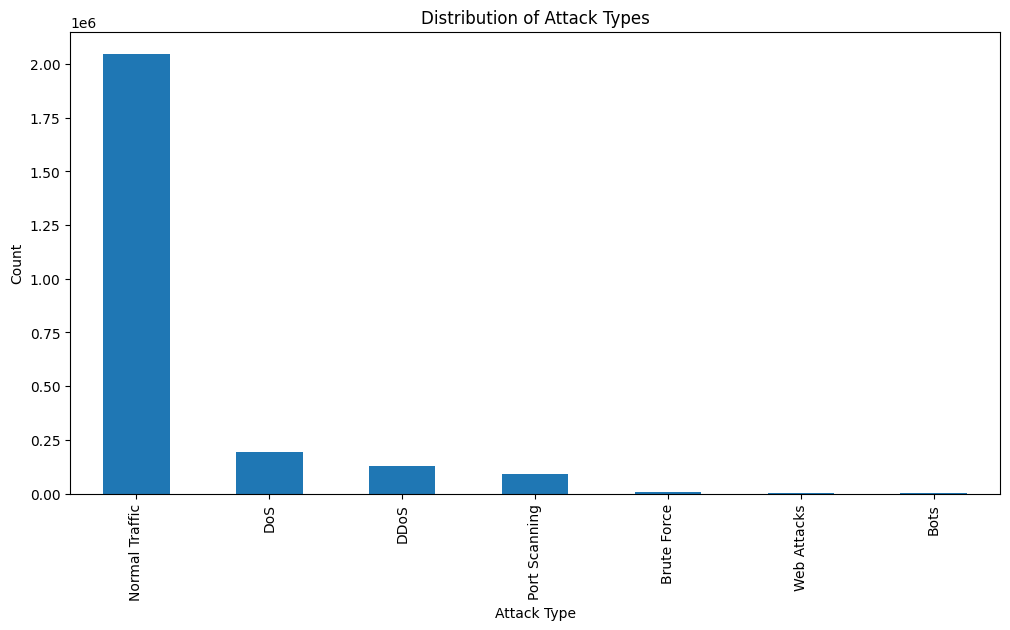

In [15]:
# visualize attack types distribution
attack_counts = df['attack_type'].value_counts()
plt.figure(figsize=(12, 6))
attack_counts.plot(kind='bar')
plt.title('Distribution of Attack Types')
plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.show()

In [16]:
# Create Binary Labels
label_col = 'attack_type'  

# Standardize text inside label
df[label_col] = df[label_col].astype(str).str.strip()

# Create binary label: 0 = BENIGN, 1 = anything else (attack)
df['binary_label'] = np.where(df[label_col].str.contains("Normal Traffic", case=False), 0, 1)

print("\nOriginal label distribution:")
print(f"\n0 (Normal): {(df['binary_label'] == 0).sum()}")
print(f"1 (Attack): {(df['binary_label'] == 1).sum()}")
print(f"Imbalance ratio: {(df['binary_label'] == 0).sum() / (df['binary_label'] == 1).sum():.2f}:1")

# Drop original label column
df = df.drop(columns=[label_col])


Original label distribution:

0 (Normal): 2048129
1 (Attack): 424704
Imbalance ratio: 4.82:1


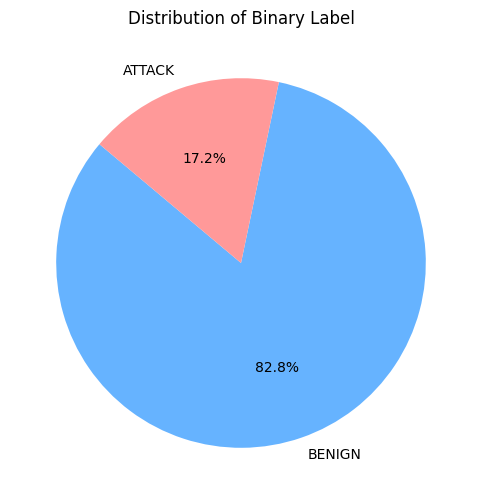

In [17]:
# pie chart
label_counts = df['binary_label'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=['BENIGN', 'ATTACK'], autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#ff9999'])
plt.title('Distribution of Binary Label')
plt.show()

In [18]:
print(df.shape)
print(df.columns)

(2472833, 51)
Index(['destination_port', 'flow_duration', 'total_fwd_packets',
       'total_length_of_fwd_packets', 'fwd_packet_length_max',
       'fwd_packet_length_min', 'fwd_packet_length_mean',
       'fwd_packet_length_std', 'bwd_packet_length_max',
       'bwd_packet_length_min', 'bwd_packet_length_mean',
       'bwd_packet_length_std', 'flow_bytes_s', 'flow_packets_s',
       'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min',
       'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max',
       'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std',
       'bwd_iat_max', 'bwd_iat_min', 'fwd_header_length', 'bwd_header_length',
       'fwd_packets_s', 'bwd_packets_s', 'min_packet_length',
       'max_packet_length', 'packet_length_mean', 'packet_length_std',
       'packet_length_variance', 'fin_flag_count', 'psh_flag_count',
       'ack_flag_count', 'average_packet_size', 'subflow_fwd_bytes',
       'act_data_pkt_fwd', 'min_seg_size_forward', 'activ

In [19]:
x = df.drop(columns=['binary_label'])
y = df['binary_label']

In [20]:
#Train set: only benign samples = model learns normal behavior
#Test set: both benign + attacks = evaluate detection

#separate benign and attack
x_benign = x[y==0]
x_attack = x[y==1]

x_train, x_val = train_test_split(x_benign, test_size=0.2, random_state=42)
        
        
x_test = np.vstack([x_val, x_attack])   #test on 20% x_val + attacks 
y_test = np.hstack([np.zeros(len(x_val)), np.ones(len(x_attack))])

In [21]:
# find mean from train set and fill nans (we're doing this step now to avoid data leakage earlier)
# this ensures no info from validation or test leaks into training

train_means = x_train.mean()
x_train = x_train.fillna(train_means)
x_val = x_val.fillna(train_means)
# x_test is numpy array
x_test = np.where(np.isnan(x_test), train_means.values, x_test)

In [ ]:
# detect outliers with iqr

Q1 = np.percentile(x_train, 25, axis=0)
Q3 = np.percentile(x_train, 75, axis=0)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count outliers per feature
outlier_counts = ((x_train < lower_bound) | (x_train > upper_bound)).sum(axis=0)
outlier_percent = outlier_counts / x_train.shape[0] * 100


outliers_df = pd.DataFrame({
    'outlier_count': outlier_counts,
    'outlier_percent': outlier_percent
})


pd.set_option('display.max_rows', None)     

display(outliers_df.sort_values('outlier_percent', ascending=False))

,outlier_count,outlier_percent
bwd_packet_length_std,392295,23.942281
flow_iat_std,388384,23.703588
fwd_iat_max,384168,23.446280
flow_iat_max,382917,23.369930
flow_duration,379861,23.183418
fwd_iat_total,376472,22.976583
fwd_iat_mean,373665,22.805268
destination_port,369001,22.520618
fwd_iat_std,363045,22.157115
packet_length_variance,354142,21.613754


In [23]:
import pandas as pd
import numpy as np

def outlier_handling(df):
    
    # Only cap EXTREME rate features (beyond realistic network limits)
    rate_features = ['flow_bytes_s', 'flow_packets_s', 'fwd_packets_s', 'bwd_packets_s']
    
    for col in rate_features:
        if col in df.columns:
            # Cap at 99.5th percentile (very conservative - only extreme errors)
            upper = df[col].quantile(0.995)
            capped = (df[col] > upper).sum()
            df[col] = np.clip(df[col], None, upper)
            print(f"  {col}: {capped} extreme values capped at {upper:.2f}")
    
    # Create log-transformed versions for model robustness
    # Keep BOTH original and log versions - let the model decide
    transform_cols = [
        'flow_duration', 'flow_bytes_s', 'flow_packets_s',
        'total_length_of_fwd_packets', 'fwd_header_length', 
        'bwd_header_length', 'packet_length_variance'
    ]
    
    for col in transform_cols:
        if col in df.columns:
            df[f'{col}_log'] = np.log1p(df[col])
            print(f"  Created {col}_log")
    
    
    return df

df = outlier_handling(df)
print(f"\nFinal shape: {df.shape}")

  flow_bytes_s: 12361 extreme values capped at 29200000.00
  flow_packets_s: 264 extreme values capped at 2000000.00
  fwd_packets_s: 153 extreme values capped at 2000000.00
  bwd_packets_s: 11898 extreme values capped at 125000.00
  Created flow_duration_log
  Created flow_bytes_s_log
  Created flow_packets_s_log
  Created total_length_of_fwd_packets_log
  Created fwd_header_length_log
  Created bwd_header_length_log
  Created packet_length_variance_log

Final shape: (2472833, 58)


In [24]:
#scaling
 
scaler = RobustScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


In [25]:
# detect outliers with iqr

Q1 = np.percentile(x_train, 25, axis=0)
Q3 = np.percentile(x_train, 75, axis=0)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count outliers per feature
outlier_counts = ((x_train < lower_bound) | (x_train > upper_bound)).sum(axis=0)
outlier_percent = outlier_counts / x_train.shape[0] * 100


outliers_df = pd.DataFrame({
    'outlier_count': outlier_counts,
    'outlier_percent': outlier_percent
})


pd.set_option('display.max_rows', None)     

display(outliers_df.sort_values('outlier_percent', ascending=False))


,outlier_count,outlier_percent
bwd_packet_length_std,392295,23.942281
flow_iat_std,388384,23.703588
fwd_iat_max,384168,23.446280
flow_iat_max,382917,23.369930
flow_duration,379861,23.183418
fwd_iat_total,376472,22.976583
fwd_iat_mean,373665,22.805268
destination_port,369001,22.520618
fwd_iat_std,363045,22.157115
packet_length_variance,354142,21.613754


In [26]:
def summary_arr(name, arr):
    print(f"\n{name}:")
    print(" shape:", arr.shape)
    print(" NANs:", np.isnan(arr).sum())
    print(" infs:", np.isinf(arr).sum())
    print(" mean:", float(np.mean(arr)))
    print(" std:", float(np.std(arr)))
    print(" min:", float(np.min(arr)))
    print(" 25%:", float(np.percentile(arr, 25)))
    print(" median:", float(np.percentile(arr, 50)))
    print(" 75%:", float(np.percentile(arr, 75)))
    print(" max:", float(np.max(arr)))

In [27]:
summary_arr("x_train", x_train_scaled)


x_train:
 shape: (1638503, 50)
 NANs: 0
 infs: 0
 mean: 256401.55756853923
 std: 3643035.3516457737
 min: -1.6666666666666667
 25%: -0.004533101715886956
 median: 0.0
 75%: 0.7507672700745505
 max: 120000000.0


In [28]:
import joblib

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
processed_path = os.path.join(project_root, "Data", "Processed")
os.makedirs(processed_path, exist_ok=True)

joblib.dump(x_train_scaled, os.path.join(processed_path, "train_scaled.pkl"))
joblib.dump(x_val_scaled, os.path.join(processed_path, "val_scaled.pkl"))
joblib.dump(x_test_scaled, os.path.join(processed_path, "test_scaled.pkl"))

['c:\\Users\\user\\Desktop\\Data\\Processed\\test_scaled.pkl']

In [29]:
#save the scaler

joblib.dump(scaler, os.path.join(processed_path, "scaler_cicids.pkl"))

['c:\\Users\\user\\Desktop\\Data\\Processed\\scaler_cicids.pkl']